# Comparing a USGSCSM and ISIS camera for Cassini ISS WAC

In [1]:
import os 
import sys

import pysis
from pysis import isis
from pysis.exceptions import ProcessError

import knoten
from knoten import vis

import json
import pvl 

import ale
from ale import util
from ale.drivers.co_drivers import CassiniIssPds3LabelNaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm
from ale.drivers import AleJsonEncoder

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

## Fetch the test image

In [2]:
imageLink = "https://pds-imaging.jpl.nasa.gov/data/cassini/cassini_orbiter/coiss_2099/data/1822296591_1822320949/W1822316594_1.IMG"
lblLink = os.path.splitext(imageLink)[0] + '.LBL'
!wget -N -P data/ {imageLink}
!wget -N -P data/ {lblLink}
fileName = 'data/' + os.path.split(lblLink)[1]

--2019-10-28 16:19:00--  https://pds-imaging.jpl.nasa.gov/data/cassini/cassini_orbiter/coiss_2099/data/1822296591_1822320949/W1822316594_1.IMG
Resolving pds-imaging.jpl.nasa.gov... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File 'data/W1822316594_1.IMG' not modified on server. Omitting download.

--2019-10-28 16:19:01--  https://pds-imaging.jpl.nasa.gov/data/cassini/cassini_orbiter/coiss_2099/data/1822296591_1822320949/W1822316594_1.LBL
Resolving pds-imaging.jpl.nasa.gov... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File 'data/W1822316594_1.LBL' not modified on server. Omitting download.



## Ingest the image, spiceinit, and create a usgscsm sensor model

In [ ]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.ciss2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)

kernels = util.get_kernels_from_isis_pvl(pvl.load(cub_loc)["IsisCube"], format_as="list")

# Isis doesn't ship IK kernels
cassini_ik_kernel = os.path.join(ale.spice_root, "co-s_j_e_v-spice-6-v1.0", "cosp_1000", "data", "ik", "cas_iss_v10.ti")
kernels.insert(0, cassini_ik_kernel) 


In [ ]:

with CassiniIssPds3LabelNaifSpiceDriver(fileName, props={"kernels": kernels}) as driver:
    usgscsm_dict = to_usgscsm(driver)

    usgscsm_dict["focal_length_model"]["focal_length"] =201.09
    csm_isd = os.path.splitext(fileName)[0] + '.json'
    json.dump(usgscsm_dict, open(csm_isd, 'w'), cls=AleJsonEncoder)
    
camera = knoten.csm.create_csm(fileName)

In [5]:
usgscsm_dict

{'radii': {'semimajor': 60268.0, 'semiminor': 54364.0, 'unit': 'km'},
 'sensor_position': {'positions': [array([1.31051432e+08, 1.59253317e+08, 2.25900234e+06])],
  'velocities': [array([  8661.20638192, -15939.43873661,    -40.92096109])],
  'unit': 'm'},
 'sun_position': {'positions': array([[1.15358173e+12, 7.05706970e+11, 6.39033844e+11]]),
  'velocities': array([[ 1.15579137e+08, -1.88931823e+08,  1.39911855e+03]]),
  'unit': 'm'},
 'sensor_orientation': {'quaternions': array([[-0.57589002, -0.27156105,  0.69725791, -0.32929727]])},
 'detector_sample_summing': 1,
 'detector_line_summing': 1,
 'focal_length_model': {'focal_length': 201.09},
 'detector_center': {'line': 512.0, 'sample': 512.0},
 'starting_detector_line': 0,
 'starting_detector_sample': 0,
 'focal2pixel_lines': [0.0, 0.0, 83.33333333333333],
 'focal2pixel_samples': [0.0, 83.33333333333333, 0.0],
 'optical_distortion': {'radial': {'coefficients': [0, -6.2e-05, 0]}},
 'image_lines': 1024,
 'image_samples': 1024,
 'name

In [6]:
cub_loc

'data/W1822316594_1.cub'

In [7]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 20, 20, 600, 600)

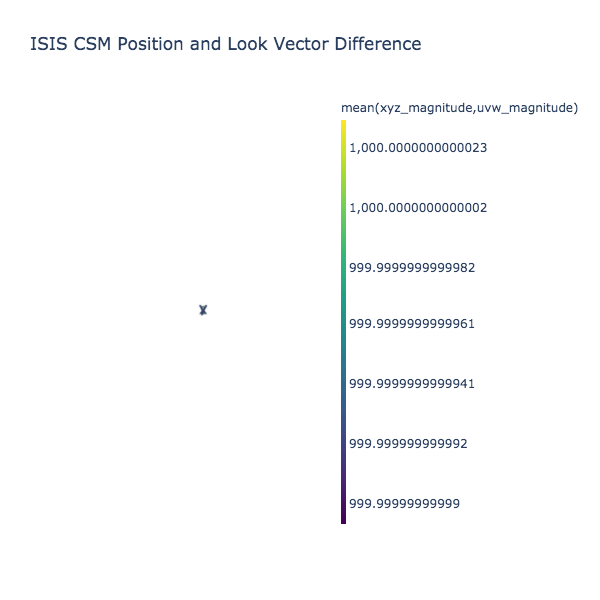

In [8]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

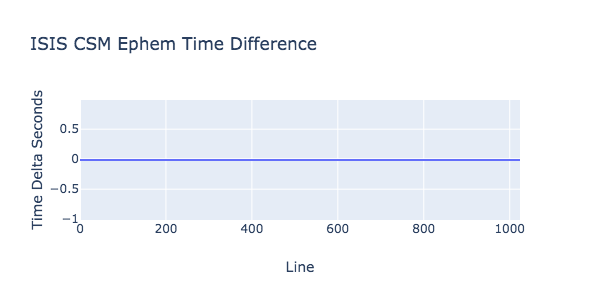

In [9]:
Image(csmisis_diff_ephem_plot_bytes)

In [10]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,-116.772242,214.901398,0.551793,624.417508,755.780918,-190.464972
std,0.000000,0.000000,0.000000,13.778108,11.541330,17.346749
min,-116.772242,214.901398,0.551793,598.132517,732.537913,-218.992811
25%,-116.772242,214.901398,0.551793,612.605784,746.070780,-204.738628
50%,-116.772242,214.901398,0.551793,624.411703,755.861215,-190.471133
75%,-116.772242,214.901398,0.551793,636.094166,765.486253,-176.153609
max,-116.772242,214.901398,0.551793,650.034135,778.191956,-161.749944


In [11]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 10, 500, 500)

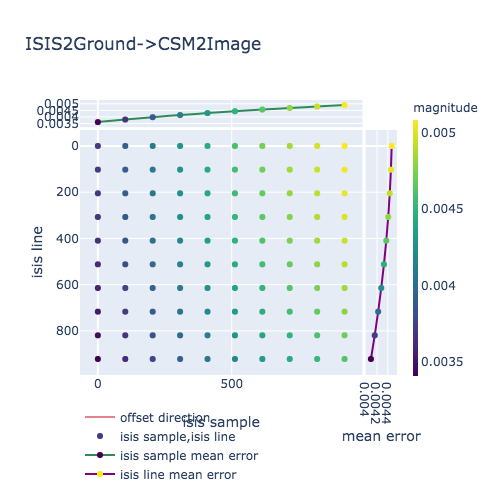

In [12]:
Image(isis2csm_plot.to_image())

In [13]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,100.000000,100.000000
mean,-0.004179,-0.001071
std,0.000484,0.000145
min,-0.005027,-0.001393
25%,-0.004578,-0.001180
50%,-0.004226,-0.001061
75%,-0.003786,-0.000961
max,-0.003118,-0.000773


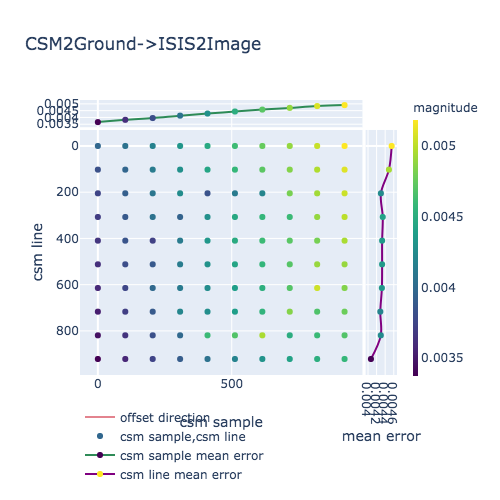

In [14]:
Image(csm2isis_plot.to_image())

In [15]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,100.000000,100.000000
mean,0.004186,0.001079
std,0.000493,0.000186
min,0.003026,0.000623
25%,0.003801,0.000952
50%,0.004205,0.001075
75%,0.004576,0.001217
max,0.005142,0.001508


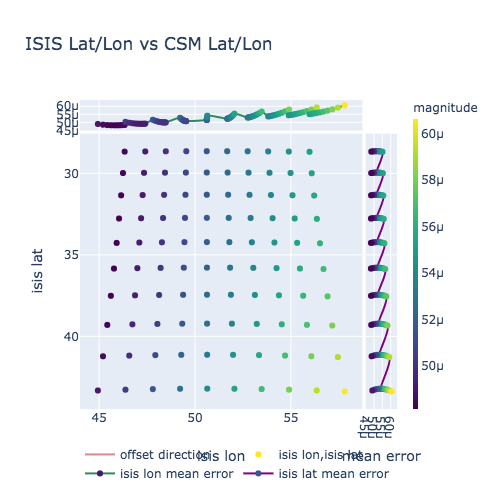

In [16]:
Image(isiscsm_plotlatlon.to_image())

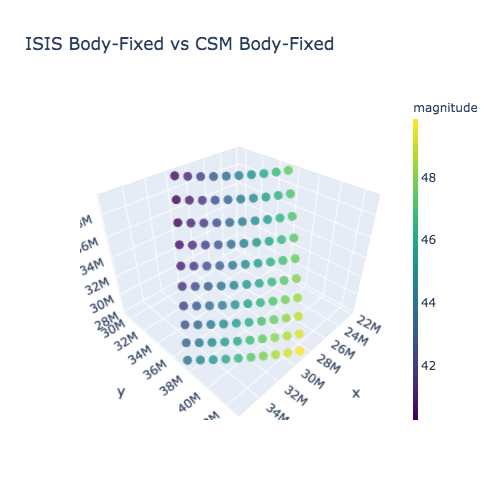

In [17]:
Image(isiscsm_plotbf.to_image())

In [18]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,100.000000,100.000000,100.000000
mean,-2.422883,-16.028499,-13.160736
std,0.278095,5.689283,2.608126
min,-2.761845,-24.263129,-18.526703
25%,-2.661876,-21.034861,-15.183479
50%,-2.488099,-16.644224,-12.926628
75%,-2.226004,-11.842966,-10.937940
max,-1.844122,-4.715998,-8.958416
